# Imports

In [56]:
# !pip install itables


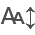

In [102]:
import pandas as pd
from researchpkg.anomaly_detection.config import AAER_DATASET_PATH
from tqdm.notebook import tqdm
import json

from itables import init_notebook_mode
init_notebook_mode(all_interactive=True)

In [103]:
all_files=list(AAER_DATASET_PATH.rglob("*.json"))

In [173]:
columns = ["aaer_no","company","role","cik","date","fiscal_quarter", "url","tags","summary"]
columns_display = ["aaer_no","company","cik","fiscal_quarter_repr", "date","role", "url","tags","summary"]

In [106]:

df_aaer = pd.DataFrame(
    {c:[] for c in columns})
for f in tqdm(all_files, desc="Reading aaer"):
    with open(f, "r") as infile:
        data = json.load(infile)["data"]
    
    for instance in data:
        aaerNo = instance["aaerNo"]
        #clear aaerNo
        aaerNo=aaerNo[:9]
        
        date = instance["dateTime"]
        
        if "tags" not in instance:
            continue
        tags = ";".join(instance["tags"])
        summary = instance["summary"]
        fiscal_quarter = ";".join(map(str,instance["fiscal_quarter"]))
        
        primary_url=[e["url"] for e in instance["urls"] if e["type"]=="primary"][0]
        
        for entity in instance["entities"]:
            if entity["type"] == "company":
                name = entity["name"]
                role = entity["role"]
                cik = entity.get("cik", None)
                
                # Append new row using loc
                df_aaer.loc[len(df_aaer)] = [
                    aaerNo,
                    name,
                    role,
                    cik,
                    date,
                    fiscal_quarter,
                    primary_url,
                    tags,
                    summary,
                    
                ]
df_aaer["date"] = pd.to_datetime(df_aaer["date"],utc=True).dt.tz_localize(None)

Reading aaer:   0%|          | 0/66 [00:00<?, ?it/s]

In [108]:
df_aaer

aaer_no                                  company              role  \
0     AAER-4147                           Illumina, Inc.    related entity   
1     AAER-4146  Argo Group International Holdings, Ltd.        respondent   
2     AAER-4145               Crown Dynamics Corporation  affected company   
3     AAER-4144        TSP Capital Management Group, LLC        respondent   
4     AAER-4141                                 KPMG LLP             other   
...         ...                                      ...               ...   
4207  AAER-3485                      Caravan Trading LLC         defendant   
4208  AAER-3485                           Cima Green LLC         defendant   
4209  AAER-3485                        CIMA Energy Group         defendant   
4210  AAER-3486         Imaging Diagnostic Systems, Inc.         defendant   
4211  AAER-3487                           Medifast, Inc.        respondent   

          cik                date  \
0     1110803 2020-06-05 13:26:57   
1     1091748 2020-06-04 13:26:57   
2        None 2020-06-03 13:26:57   
3     1317208 2020-05-22 13:26:59   
4        None 2020-05-18 13:26:59   
...       ...                 ...   
4207     None 2013-09-18 14:25:12   
4208     None 2013-09-18 14:25:12   
4209     None 2013-09-18 14:25:12   
4210     None 2013-09-18 14:25:12   
4211   910329 2013-09-18 13:20:13   

                                         fiscal_quarter  \
0                                                2019q2   
1     2014q1;2014q2;2014q3;2014q4;2015q1;2015q2;2015...   
2                    2011q4;2012q1;2012q2;2012q3;2012q4   
3     2014q1;2014q2;2014q3;2014q4;2015q1;2015q2;2015...   
4                                                         
...                                                 ...   
4207          2010q2;2010q3;2010q4;2011q1;2011q2;2011q3   
4208          2010q2;2010q3;2010q4;2011q1;2011q2;2011q3   
4209          2010q2;2010q3;2010q4;2011q1;2011q2;2011q3   
4210  2008q4;2009q1;2009q2;2009q3;2009q4;2010q1;2010...   
4211  2006q1;2006q2;2006q3;2006q4;2007q1;2007q2;2007...   

                                                    url  \
0     https://www.sec.gov/files/litigation/admin/202...   
1     https://www.sec.gov/files/litigation/admin/202...   
2     https://www.sec.gov/files/litigation/admin/202...   
3     https://www.sec.gov/files/litigation/admin/202...   
4     https://www.sec.gov/files/litigation/admin/202...   
...                                                 ...   
4207  https://www.sec.gov/enforcement-litigation/lit...   
4208  https://www.sec.gov/enforcement-litigation/lit...   
4209  https://www.sec.gov/enforcement-litigation/lit...   
4210  https://www.sec.gov/enforcement-litigation/lit...   
4211  https://www.sec.gov/files/litigation/admin/201...   

                                                   tags  \
0                                       insider trading   
1                                      disclosure fraud   
2                  market manipulation;securities fraud   
3         disclosure violations;custody rule violations   
4              professional misconduct;accounting fraud   
...                                                 ...   
4207  disclosure fraud;securities fraud;renewable en...   
4208  disclosure fraud;securities fraud;renewable en...   
4209  disclosure fraud;securities fraud;renewable en...   
4210                             fraud;disclosure fraud   
4211             disclosure fraud;accounting violations   

                                                summary  
0     The SEC has instituted proceedings against Jan...  
1     The SEC has ordered Argo Group International H...  
2     The SEC has instituted administrative proceedi...  
3     The SEC has instituted administrative and ceas...  
4     The SEC has instituted proceedings against Tim...  
...                                                 ...  
4207  The SEC charged Imperial Petroleum, its execut...  
4208  The SEC charged Imperial Petr

In [254]:
df_aaer["fiscal_quarter"]= df_aaer["fiscal_quarter"].apply(lambda x : ";".join(list(set(x.strip().split(";")))))

def simply_fiscal_quarter(fiscal_quarter:str):
    all_quarters = fiscal_quarter.split(";")
    quarter_year_pair=list(set([(q[:4],q[4:]) for q in all_quarters]))
    quarters_per_year={}
    for y,q in quarter_year_pair:
        quarters_per_year.setdefault(y,[]).append(q)
    
    quarters_per_year= dict(sorted(quarters_per_year.items(),key=lambda x: int(x[0]) if x[0]!='' else 1))
    
    repr=""
    for y in quarters_per_year:
        quarters_per_year[y]=list(sorted(quarters_per_year[y]))
        if len(quarters_per_year[y])==4:
            repr+=f"{y}  "
        else:
            repr+=f"{y}({','.join(quarters_per_year[y])})  "
            

    return repr



df_aaer["fiscal_quarter_repr"]= df_aaer["fiscal_quarter"].apply(simply_fiscal_quarter)



In [255]:
df_aaer["fiscal_quarter_repr"]

0                                   2019(q2)  
1               2014  2015  2016  2017  2018  
2                             2011(q4)  2012  
3               2014  2015  2016  2017  2018  
4                                         ()  
                         ...                  
4207          2010(q2,q3,q4)  2011(q1,q2,q3)  
4208          2010(q2,q3,q4)  2011(q1,q2,q3)  
4209          2010(q2,q3,q4)  2011(q1,q2,q3)  
4210    2008(q4)  2009  2010  2011(q1,q2,q3)  
4211                  2006  2007  2008  2009  
Name: fiscal_quarter_repr, Length: 4212, dtype: object

In [256]:
# Number of distinct companies
print ("Num companies :", df_aaer.company.nunique())

Num companies : 2144


In [257]:
### Company  names with distinct CIK
df_aaer["num_cik"] = df_aaer.groupby("company")["cik"].transform("nunique")
df_aaer.query("num_cik > 1").sort_values("company")
#NO company with distinct CIK

Empty DataFrame
Columns: [aaer_no, company, role, cik, date, fiscal_quarter, url, tags, summary, num_cik, fiscal_quarter_repr]
Index: []

In [258]:
#Company with CIK none
df_aaer[df_aaer.cik.isna()]["company"].nunique()

1316

## 2.Tags distribution

In [259]:
print("Number of rows:", len(df_aaer))

Number of rows: 4212


In [260]:
tags_list = df_aaer["tags"].tolist()
splitted_tags = [tag for row in tags_list for tag in row.split(";")]
tag_counts = pd.Series(splitted_tags).value_counts().to_frame()
# Increase the number of displayed rows
pd.set_option("display.max_rows",100)
tag_counts


0
disclosure fraud                 2062
accounting fraud                 1336
securities fraud                  494
improper professional conduct     429
financial fraud                   298
...                               ...
compliance failures                 1
principal transactions              1
accounting control deficiencies     1
improper auditing practices         1
misleading auditors                 1

[432 rows x 1 columns]

In [261]:
FRAUD_KEYWORDS=["fraud","manipulation","misappropriation","false_reporting"]

In [262]:
retained_tags = []
for tag in tags_list:
    if len([k for k in FRAUD_KEYWORDS if k in tag])>0:
        retained_tags.append(tag)
other_tags = [t for t in tags_list if t not in retained_tags]
other_tags

['insider trading',
 'disclosure violations;custody rule violations',
 'disgorgement',
 'improper professional conduct;audit documentation violations;securities law violations',
 'accounting misconduct;reinstatement',
 'accounting misconduct;reinstatement',
 'accounting misconduct;reinstatement',
 'audit deficiencies;securities violations;professional misconduct',
 'audit deficiencies;securities violations;professional misconduct',
 'internal controls violation;FCPA violation;recordkeeping violation',
 'auditing deficiencies;improper professional conduct',
 'auditing deficiencies;improper professional conduct',
 'improper professional conduct;auditing violations',
 'accounting violations;reinstatement',
 'accounting enforcement',
 'corruption;bribery;foreign corrupt practices',
 'reinstatement;improper professional conduct',
 'internal control failures;securities law violations',
 'audit failure;professional misconduct;securities violation',
 'audit failure;professional misconduct;secu

In [263]:
print("Num retained tags :",len(retained_tags))
print("Num other tags :",len(other_tags))

Num retained tags : 3159
Num other tags : 1053


In [264]:
other_tags

['insider trading',
 'disclosure violations;custody rule violations',
 'disgorgement',
 'improper professional conduct;audit documentation violations;securities law violations',
 'accounting misconduct;reinstatement',
 'accounting misconduct;reinstatement',
 'accounting misconduct;reinstatement',
 'audit deficiencies;securities violations;professional misconduct',
 'audit deficiencies;securities violations;professional misconduct',
 'internal controls violation;FCPA violation;recordkeeping violation',
 'auditing deficiencies;improper professional conduct',
 'auditing deficiencies;improper professional conduct',
 'improper professional conduct;auditing violations',
 'accounting violations;reinstatement',
 'accounting enforcement',
 'corruption;bribery;foreign corrupt practices',
 'reinstatement;improper professional conduct',
 'internal control failures;securities law violations',
 'audit failure;professional misconduct;securities violation',
 'audit failure;professional misconduct;secu

## 3. Filter by tags keywords

In [265]:
df_aaer_filtered = df_aaer.query(f"tags in {retained_tags}")

In [266]:
df_aaer_filtered

aaer_no                                  company  \
1     AAER-4146  Argo Group International Holdings, Ltd.   
2     AAER-4145               Crown Dynamics Corporation   
4     AAER-4141                                 KPMG LLP   
5     AAER-4142                                 KPMG LLP   
6     AAER-4143                                 KPMG LLP   
...         ...                                      ...   
4207  AAER-3485                      Caravan Trading LLC   
4208  AAER-3485                           Cima Green LLC   
4209  AAER-3485                        CIMA Energy Group   
4210  AAER-3486         Imaging Diagnostic Systems, Inc.   
4211  AAER-3487                           Medifast, Inc.   

                       role      cik                date  \
1                respondent  1091748 2020-06-04 13:26:57   
2          affected company     None 2020-06-03 13:26:57   
4                     other     None 2020-05-18 13:26:59   
5                     other     None 2020-05-18 13:26:59   
6     other relevant entity     None 2020-05-18 13:26:59   
...                     ...      ...                 ...   
4207              defendant     None 2013-09-18 14:25:12   
4208              defendant     None 2013-09-18 14:25:12   
4209              defendant     None 2013-09-18 14:25:12   
4210              defendant     None 2013-09-18 14:25:12   
4211             respondent   910329 2013-09-18 13:20:13   

                                         fiscal_quarter  \
1     2015q1;2016q4;2017q3;2014q2;2018q2;2015q4;2015...   
2                    2012q1;2012q3;2012q2;2012q4;2011q4   
4                                                         
5                                                         
6                                                         
...                                                 ...   
4207          2011q2;2010q2;2010q3;2011q1;2010q4;2011q3   
4208          2011q2;2010q2;2010q3;2011q1;2010q4;2011q3   
4209          2011q2;2010q2;2010q3;2011q1;2010q4;2011q3   
4210  2008q4;2011q2;2010q1;2009q1;2009q3;2009q2;2010...   
4211  2008q4;2007q3;2008q1;2007q4;2008q2;2006q1;2009...   

                                                    url  \
1     https://www.sec.gov/files/litigation/admin/202...   
2     https://www.sec.gov/files/litigation/admin/202...   
4     https://www.sec.gov/files/litigation/admin/202...   
5     https://www.sec.gov/files/litigation/admin/202...   
6     https://www.sec.gov/files/litigation/admin/202...   
...                                                 ...   
4207  https://www.sec.gov/enforcement-litigation/lit...   
4208  https://www.sec.gov/enforcement-litigation/lit...   
4209  https://www.sec.gov/enforcement-litigation/lit...   
4210  https://www.sec.gov/enforcement-litigation/lit...   
4211  https://www.sec.gov/files/litigation/admin/201...   

                                                   tags  \
1                                      disclosure fraud   
2                  market manipulation;securities fraud   
4              professional misconduct;accounting fraud   
5              professional misconduct;accounting fraud   
6              professional misconduct;accounting fraud   
...                                                 ...   
4207  disclosure fraud;securities fraud;renewable en...   
4208  disclosure fraud;securities fraud;renewable en...   
4209  disclosure fraud;securities fraud;renewable en...   
4210                             fraud;disclosure fraud   
4211             disclosure fraud;accounting violations   

                                                summary  num_cik  \
1     The SEC has ordered Argo Group International H...        1   
2     The SEC has instituted administrative proceedi...        0   
4     The SEC has instituted proceedings against Tim...        0   
5     The SEC has instituted public administrative a...        0   
6     The SEC has instituted proceedings against Joh...        0   
...                            

In [267]:
df_aaer_filtered=df_aaer_filtered[~df_aaer_filtered.cik.isna()]

In [268]:
df_aaer_filtered

aaer_no                                  company            role  \
1     AAER-4146  Argo Group International Holdings, Ltd.      respondent   
14    AAER-4133                     Obsidian Energy Ltd.       defendant   
17    AAER-4128              Liquid Holdings Group, Inc.        violator   
19    AAER-4129              Liquid Holdings Group, Inc.        violator   
21    AAER-4127              Liquid Holdings Group, Inc.  related entity   
...         ...                                      ...             ...   
4192  AAER-3499                       Mercantile Bancorp       defendant   
4200  AAER-3494                   Universal Travel Group       defendant   
4202  AAER-3493                 Mercantile Bancorp, Inc.       defendant   
4205  AAER-3490                     JPMorgan Chase & Co.      respondent   
4211  AAER-3487                           Medifast, Inc.      respondent   

          cik                date  \
1     1091748 2020-06-04 13:26:57   
14    1334388 2020-04-28 14:27:02   
17    1562594 2020-04-22 13:27:02   
19    1562594 2020-04-22 13:27:02   
21    1562594 2020-04-22 13:27:02   
...       ...                 ...   
4192  1289701 2013-09-30 13:20:10   
4200  1336644 2013-09-27 14:25:13   
4202  1289701 2013-09-26 14:25:13   
4205    19617 2013-09-19 13:20:12   
4211   910329 2013-09-18 13:20:13   

                                         fiscal_quarter  \
1     2015q1;2016q4;2017q3;2014q2;2018q2;2015q4;2015...   
14    2013q4;2013q1;2012q1;2014q1;2012q3;2012q2;2013...   
17                          2013q4;2014q2;2014q1;2013q3   
19                          2013q4;2014q2;2014q1;2013q3   
21                                        2013q4;2013q3   
...                                                 ...   
4192                                             2010q3   
4200  2008q4;2011q2;2008q3;2010q1;2009q1;2009q3;2009...   
4202                                             2010q3   
4205                                             2012q1   
4211  2008q4;2007q3;2008q1;2007q4;2008q2;2006q1;2009...   

                                                    url  \
1     https://www.sec.gov/files/litigation/admin/202...   
14    https://www.sec.gov/enforcement-litigation/lit...   
17    https://www.sec.gov/files/litigation/admin/202...   
19    https://www.sec.gov/files/litigation/admin/202...   
21    https://www.sec.gov/files/litigation/admin/202...   
...                                                 ...   
4192  https://www.sec.gov/files/litigation/admin/201...   
4200  https://www.sec.gov/enforcement-litigation/lit...   
4202  https://www.sec.gov/enforcement-litigation/lit...   
4205  https://www.sec.gov/files/litigation/admin/201...   
4211  https://www.sec.gov/files/litigation/admin/201...   

                                                   tags  \
1                                      disclosure fraud   
14                    accounting fraud;disclosure fraud   
17                                     disclosure fraud   
19                                     disclosure fraud   
21               disclosure fraud;securities violations   
...                                                 ...   
4192                  accounting fraud;disclosure fraud   
4200       disclosure fraud;financial misrepresentation   
4202           financial misstatements;disclosure fraud   
4205  disclosure fraud;internal controls;financial m...   
4211             disclosure fraud;accounting violations   

                                                summary  num_cik  \
1     The SEC has ordered Argo Group International H...        1   
14    The SEC announced settlements with former fina...        1   
17    The SEC has instituted cease-and-desist procee...        1   
19    The SEC has instituted cease-and-desist procee...        1   
21    The SEC has instituted cease-and-desist procee...        1   
...                                                 ...      ...   
4192  The SEC has instituted administrative pro

In [269]:
roles_count=df_aaer_filtered.role.value_counts().to_frame()
roles_count

role
defendant                                           321
respondent                                          237
involved company                                    154
affected company                                    131
other                                               106
company involved                                     75
entity involved                                      71
related entity                                       54
involved party                                       32
violator                                             27
related party                                        19
parent company                                       16
entity involved in fraud                             14
subject of audit                                     13
other relevant entity                                13
audited company                                      12
employer                                             12
relevant entity                                      10
issuer                                               10
subsidiary                                            9
involved                                              8
subject                                               7
subject of investigation                              7
entity involved in the violations                     6
affected party                                        5
client                                                5
subject of fraud                                      5
involved entity                                       5
victim                                                5
entity involved in the fraud                          5
entity audited                                        4
entity involved in the scheme                         4
vendor                                                4
associated entity                                     4
entity involved in the misconduct                     3
subsidiary involved in fraud                          3
former employer                                       3
company involved in the fraudulent scheme             3
entity involved in fraudulent conduct                 3
subject of the fraud                                  2
entity involved in the case                           2
audit client                                          2
affected entity                                       2
entity involved in fraudulent activities              2
auditee                                               2
entity involved in violations                         2
other relevant party                                  1
acquirer                                              1
perpetrator                                           1
company involved in misconduct                        1
successor entity                                      1
entity controlled by respondent                       1
parent company affected by fraud                      1
entity involved in the allegations                    1
related company                                       1
subject of the complaint                              1
customer                                              1
parent company affected by financial misreporting     1
company                                               1
subject of prior enforcement action                   1
entity involved in fraudulent scheme                  1
employer of defendant                                 1
landlord affected by the scheme                       1
predecessor company                                   1
entity involved in fraudulent transaction             1
entity involved in joint venture                      1
registered investment adviser                         1
entity involved in financial misstatement             1
issuer involved                                       1
insurance provider                                    1
associated firm                                       1
seller of accountin

<Axes: >

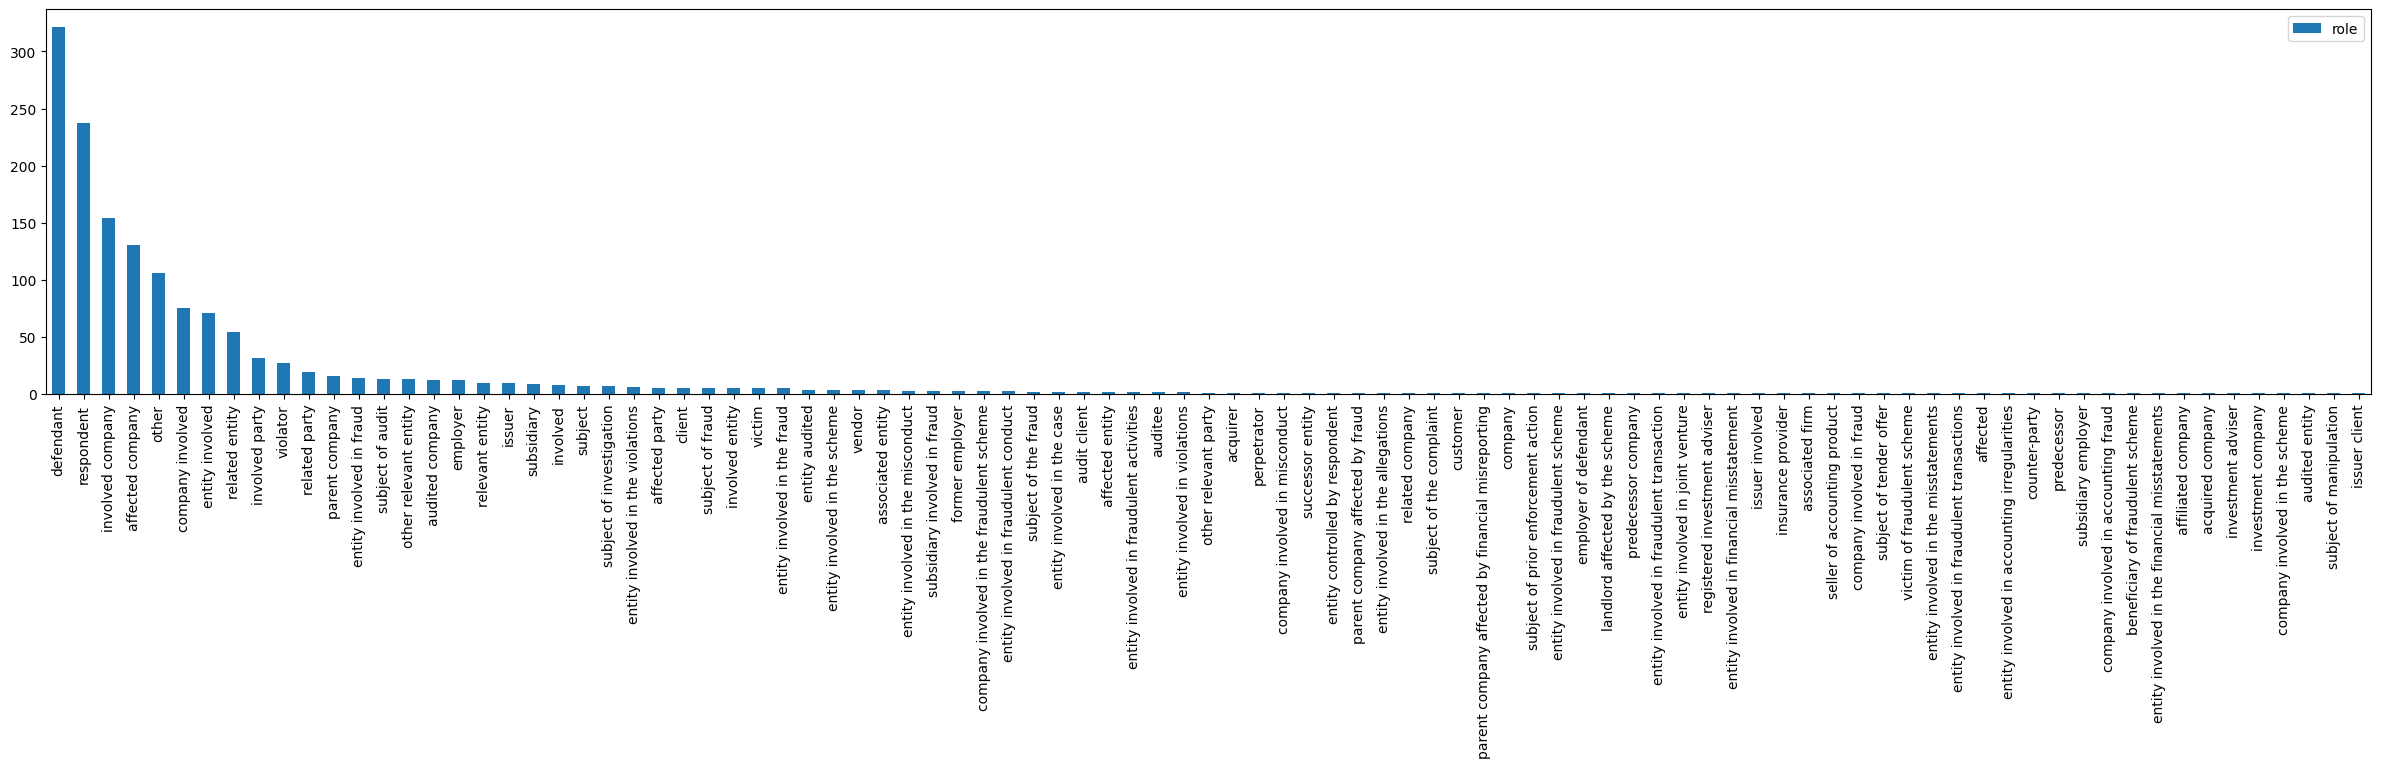

In [270]:
roles_count.plot(kind="bar",figsize=(30,5))

In [271]:
NON_FRAUDULENT_ROLES = [
    "affected company",
    "other",
    "employer",
    "relevant entity",
    "subsidiary",
    "victim",
    "client",
    "affected party",
    "associated entity",
    "vendor",
    "entity audited",
    "former employer",
    "affected entity",
    "audit client",
    "issuer client",
    "subject of manipulation",
    "audited entity",
    "investment company",
    "investment adviser",
    "acquired company",
    "affiliated company",
    "subsidiary employer",
    "predecessor",
    "counter-party",
    "affected",
    "victim of fraudulent scheme",
    "subject of tender offer",
    "seller of accounting product",
    "associated firm",
    "insurance provider",
    "registered investment adviser",
    "entity involved in joint venture",
    "predecessor company",
    "landlord affected by the scheme",
    "employer of defendant",
    "subject of prior enforcement action",
    "company",
    "parent company affected by financial misreporting",
    "customer",
    "subject of the complaint",
    "related company",
    "entity controlled by respondent",
    "successor entity",
    "acquirer",
    "other relevant party"
]

In [272]:
df_aaer_filtered = df_aaer_filtered.query(f"role not in {NON_FRAUDULENT_ROLES}")

In [273]:
df_aaer_filtered_from_2009= df_aaer_filtered[(df_aaer_filtered['date'].dt.year >= 2009)  ]
df_aaer_filtered_from_2009[columns_display]

aaer_no                                  company      cik  \
1     AAER-4146  Argo Group International Holdings, Ltd.  1091748   
14    AAER-4133                     Obsidian Energy Ltd.  1334388   
17    AAER-4128              Liquid Holdings Group, Inc.  1562594   
19    AAER-4129              Liquid Holdings Group, Inc.  1562594   
21    AAER-4127              Liquid Holdings Group, Inc.  1562594   
...         ...                                      ...      ...   
4192  AAER-3499                       Mercantile Bancorp  1289701   
4200  AAER-3494                   Universal Travel Group  1336644   
4202  AAER-3493                 Mercantile Bancorp, Inc.  1289701   
4205  AAER-3490                     JPMorgan Chase & Co.    19617   
4211  AAER-3487                           Medifast, Inc.   910329   

                         fiscal_quarter_repr                date  \
1             2014  2015  2016  2017  2018   2020-06-04 13:26:57   
14                    2012  2013  2014(q1)   2020-04-28 14:27:02   
17                2013(q3,q4)  2014(q1,q2)   2020-04-22 13:27:02   
19                2013(q3,q4)  2014(q1,q2)   2020-04-22 13:27:02   
21                             2013(q3,q4)   2020-04-22 13:27:02   
...                                      ...                 ...   
4192                              2010(q3)   2013-09-30 13:20:10   
4200  2008(q3,q4)  2009  2010  2011(q1,q2)   2013-09-27 14:25:13   
4202                              2010(q3)   2013-09-26 14:25:13   
4205                              2012(q1)   2013-09-19 13:20:12   
4211                2006  2007  2008  2009   2013-09-18 13:20:13   

                role                                                url  \
1         respondent  https://www.sec.gov/files/litigation/admin/202...   
14         defendant  https://www.sec.gov/enforcement-litigation/lit...   
17          violator  https://www.sec.gov/files/litigation/admin/202...   
19          violator  https://www.sec.gov/files/litigation/admin/202...   
21    related entity  https://www.sec.gov/files/litigation/admin/202...   
...              ...                                                ...   
4192       defendant  https://www.sec.gov/files/litigation/admin/201...   
4200       defendant  https://www.sec.gov/enforcement-litigation/lit...   
4202       defendant  https://www.sec.gov/enforcement-litigation/lit...   
4205      respondent  https://www.sec.gov/files/litigation/admin/201...   
4211      respondent  https://www.sec.gov/files/litigation/admin/201...   

                                                   tags  \
1                                      disclosure fraud   
14                    accounting fraud;disclosure fraud   
17                                     disclosure fraud   
19                                     disclosure fraud   
21               disclosure fraud;securities violations   
...                                                 ...   
4192                  accounting fraud;disclosure fraud   
4200       disclosure fraud;financial misrepresentation   
4202           financial misstatements;disclosure fraud   
4205  disclosure fraud;internal controls;financial m...   
4211             disclosure fraud;accounting violations   

                                                summary  
1     The SEC has ordered Argo Group International H...  
14    The SEC announced settlements with former fina...  
17    The SEC has instituted cease-and-desist procee...  
19    The SEC has instituted cease-and-desist procee...  
21    The SEC has instituted cease-and-desist procee...  
...                                                 ...  
4192  The SEC has instituted administrative proceedi...  
4200  The SEC filed fraud charges against Universal ...  
4202  The SEC charged two former executives of Merca...  
4205  The SEC has instituted cease-and-desist procee...  
4211  The SEC has instituted cease-and-desist procee...  

[473 rows x 9 columns]

In [276]:
df_aaer_filtered_from_2009.to_excel("df_aaer_filtered_from_2009_v1.xlsx")
df_aaer_filtered.to_excel("df_aaer_filtered_v1.xlsx")
df_aaer.to_excel("df_aaer_full_v1.xlsx")

In [ ]:
f

# Test balance sheets and income statements extraction

In [278]:
# BEFORE 2009 (No Xbrl, so errors)


In [280]:
from sec_api import XbrlApi

from researchpkg.anomaly_detection.config import SEC_API_TOKEN
xbrl_api = XbrlApi(SEC_API_TOKEN)

#"filedAt": "1993-11-29T00:00:00-05:00" for the following file
fileUrl = "https://www.sec.gov/Archives/edgar/data/861439/0000912057-94-000263-index.html"

xbrl_json = xbrl_api.xbrl_to_json(fileUrl)

Exception: API error: 404 - {"status":404,"error":"The filer did not attach XBRL data to the filing. A conversion is not possible."}

In [279]:
# SINCE 2009, XBRL

## Explore AAER of a dataset version (for post annotation)

In [ ]:
from researchpkg.anomaly_detection.config import PREPROCESSED_PATH_EXTENDED


VERSION= "V4"
INDEX_PATH  = PREPROCESSED_PATH_EXTENDED